In [40]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as osp
import imageio
from tqdm import tqdm
from transforms3d.euler import mat2euler, euler2mat
import pyrender
import trimesh
import cv2

EPS = 1e-8

from utils import viz_camera_poses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
# Load data
from dataloader import load_middlebury_data
DATA = load_middlebury_data("data/templeRing")
# reference: https://vision.middlebury.edu/mview/


Loading data/templeRing


47it [00:00, 91.24it/s]


In [42]:
ref_view = DATA[2]
neighbor_views = [DATA[i] for i in [0, 1, 3, 4]]


In [43]:
for view in neighbor_views:
    assert view['rgb'].shape == ref_view['rgb'].shape  
height, width = ref_view['rgb'].shape[:2]


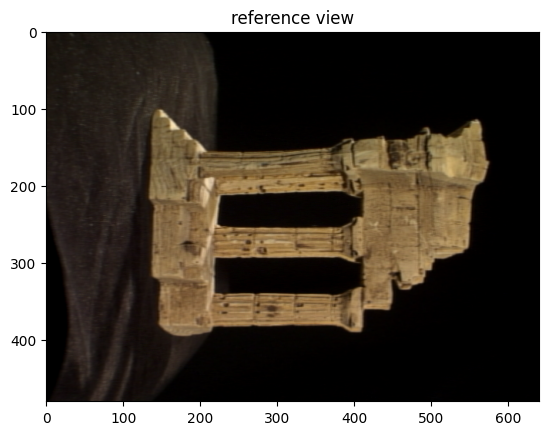

In [44]:
plt.title("reference view")
plt.imshow(ref_view["rgb"])
plt.show()

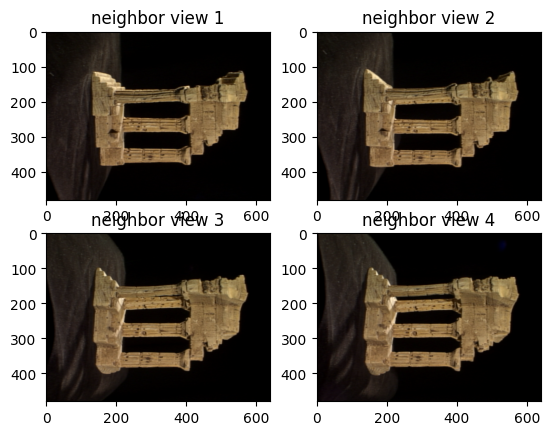

In [45]:
for i, view in enumerate(neighbor_views):
    plt.subplot(2, 2, i+1)
    plt.title("neighbor view " + str(i+1)) 
    plt.imshow(view["rgb"])
plt.show()

In [46]:
## vector of depths to sweep our plane across 
def get_depths(min_depth, max_depth, num_depths):
    depths = np.linspace(min_depth, max_depth, num_depths)
    return np.float32(depths)

In [47]:
min_depth = 0.52 
max_depth = 0.62 
num_depths = 25

depths = get_depths(min_depth, max_depth, num_depths)
depths

array([0.52      , 0.52416664, 0.5283333 , 0.5325    , 0.5366667 ,
       0.54083335, 0.545     , 0.5491667 , 0.55333334, 0.5575    ,
       0.56166667, 0.56583333, 0.57      , 0.57416666, 0.5783333 ,
       0.5825    , 0.58666664, 0.5908333 , 0.595     , 0.5991667 ,
       0.60333335, 0.6075    , 0.6116667 , 0.61583334, 0.62      ],
      dtype=float32)

The planes will be swept fronto-parallel to the reference camera, so no
reprojection needs to be done for this image.  Simply compute the normalized
patches across the entire image.

In [48]:
from two_view_stereo import image2patch

ref_view_patches = image2patch(ref_view['rgb'].astype(np.float)/255.0, k_size=5) # [h,w,k*k,3]
ref_view_patches.shape


C:\Users\Akash\AppData\Local\Temp\ipykernel_19572\1713906341.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ref_view_patches = image2patch(ref_view['rgb'].astype(np.float)/255.0, k_size=5) # [h,w,k*k,3]


(480, 640, 25, 3)

We'll sweep a series of planes that are fronto-parallel to the right camera.
The image from the left camera is to be projected onto each of these planes,
normalized, and then compared to the normalized right image.


In [49]:
from plane_sweep_stereo import backproject_corners, project_points, warp_neighbor_to_ref, zncc_kernel_2D
volume = []

## for each depth, compute and sum the disparity maps between ref and each neighboring view
for depth in tqdm(depths):
    zncc = np.zeros((height, width))
    for neighbor_view in neighbor_views:

        K_ref = ref_view['K']
        K_neighbor = neighbor_view['K']
        
        R_ref = ref_view['R']
        t_ref = np.expand_dims(ref_view['T'], axis=1)
        Rt_ref = np.hstack((R_ref, t_ref))
        
        R_neighbor = neighbor_view['R']
        t_neighbor = np.expand_dims(neighbor_view['T'], axis=1)
        Rt_neighbor = np.hstack((R_neighbor, t_neighbor))

        warped_neighbor = warp_neighbor_to_ref(backproject_corners, project_points, depth, neighbor_view['rgb'], K_ref, Rt_ref, K_neighbor, Rt_neighbor)
       
        # patchify this warped left image.

        neighbor_view_patches = image2patch(warped_neighbor.astype(np.float)/255.0, k_size=5)

        # Compute the ZNCC score between the reference and neighbor images.
        ## summing zncc scores across all neighboring views
        zncc += zncc_kernel_2D(ref_view_patches, neighbor_view_patches)
        
    #     break
    # break

    volume.append(zncc)


  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\Akash\AppData\Local\Temp\ipykernel_19572\2921342167.py:24: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  neighbor_view_patches = image2patch(warped_neighbor.astype(np.float)/255.0, k_size=5)
100%|██████████| 25/25 [32:53<00:00, 78.95s/it]


In [50]:

# All of these separate ZNCC layers get stacked together into a volume.
volume_np = np.dstack(volume)

# We're going to use the simplest algorithm to select a depth layer per pixel --
# the argmax across depth labels.
vol_argmax = volume_np.argmax(axis=2)

# Remap the label IDs back to their associated depth values.
depth_map = depths[vol_argmax]



# Visualize the cost volume:

In [51]:
from IPython.display import Image
from copy import deepcopy
volume_np_viz = deepcopy(volume_np)
volume_np_viz =  volume_np_viz -  volume_np_viz.min()
volume_np_viz = volume_np_viz  / volume_np_viz.max()
frames = [(volume_np_viz[:,:,i]*255).astype(np.uint8) for i in range(volume_np_viz.shape[-1])]
imageio.mimsave("./volume_np.gif",frames, fps=10)

<img src="volume_np.gif" width="750" align="center">

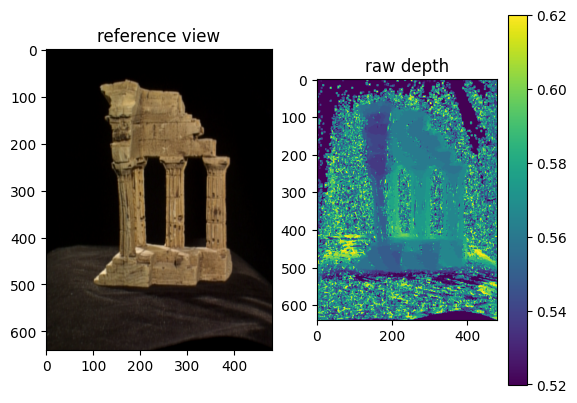

In [52]:
plt.subplot(1,2,1)
plt.title("reference view")
plt.imshow(cv2.rotate(ref_view["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))

plt.subplot(1,2,2)
plt.title("raw depth")
plt.imshow(cv2.rotate(depth_map, cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.colorbar()
plt.show()

### Postprocessing and visualization

C:\Users\Akash\AppData\Local\Temp\ipykernel_19572\2579144256.py:15: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = (mask > 0).astype(np.float)


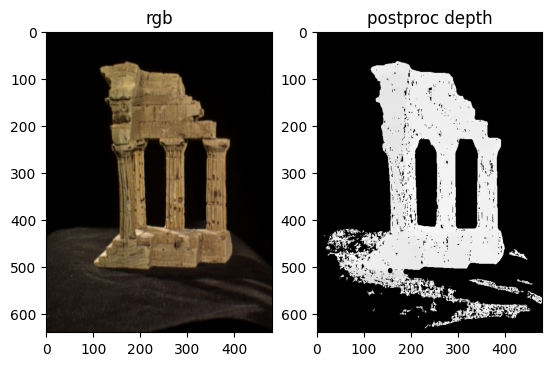

In [53]:
from plane_sweep_stereo import backproject
from two_view_stereo import postprocess
xyz_cam = backproject(depth_map, K_ref)

mask, pcl_world, pcl_cam, pcl_color = postprocess(
    depth_map,
    ref_view["rgb"],
    xyz_cam,
    R_wc=ref_view["R"],
    T_wc=ref_view["T"][:,None],
    z_near=0.5,
    z_far=0.6,
)

mask = (mask > 0).astype(np.float)

plt.subplot(1, 2, 1)
plt.title("rgb")
plt.imshow(cv2.rotate(ref_view["rgb"], cv2.ROTATE_90_COUNTERCLOCKWISE))
plt.subplot(1, 2, 2)
plt.title("postproc depth")
plt.imshow(cv2.rotate(depth_map * mask, cv2.ROTATE_90_COUNTERCLOCKWISE), cmap="gray")
plt.show()


In [54]:
import k3d
import numpy as np

def viz_3d_embedded(pcl, color):
    plot = k3d.plot(camera_auto_fit=True)
    color = color.astype(np.uint8)
    color32 = (color[:, 0] * 256**2 + color[:, 1] * 256**1 + color[:, 2] * 256**0).astype(
        np.uint32
    )
    plot += k3d.points(pcl.astype(float), color32, point_size=0.001, shader="flat")
    plot.display()

In [55]:
viz_3d_embedded(pcl_world, pcl_color.astype(np.uint8))

c:\Users\Akash\AppData\Local\Programs\Python\Python39\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "float64" does not match required type "float32". A coerced copy has been created.
  warnings.warn(
c:\Users\Akash\AppData\Local\Programs\Python\Python39\lib\site-packages\traittypes\traittypes.py:97: UserWarning: Given trait value dtype "uint32" does not match required type "uint32". A coerced copy has been created.
  warnings.warn(


Output()